# Analysis of Solomon 8.15.18 MOES Quantitative Data Final
A lot of code, Curtis, and not particularly useful to you, I'm sure.

## Class panda_reader()
## Utility class to get a panda df from Excel

In [18]:
import pandas as pd
import numpy as np
import unittest
import logging
import os.path
from pandas.util.testing import assert_frame_equal
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class panda_reader():
    filename = None
    worksheetname = None
    df = None
    

    # Getters and setters for filename, worksheetname, and df
    def getFilename(self):
        if self.filename is None:
            logger.info('filename is not yet set!!')
            return None
        else:
            logger.debug('About to return current filename, which is: ' + self.filename)
        
        return self.filename
        
    # Setter for filename. Returns True if the file was found, False otherwise. 
    # Results can be disregarded if you are writing the file. 
    def setFilename(self, fn):
        logger.debug('About to set filename to: ' + fn)
        self.filename = fn
        if not os.path.isfile(fn):
            logger.warning('Cannot find file ' + fn)
            return False
        return True

        
    def getWorksheetName(self):
        return self.worksheetname
    
    def setWorksheetName(self, wks):
        logger.debug('About to set worksheet to: ' + wks)
        self.worksheetname = wks
        
    def getDf(self):
        return self.df

    # Return a tiny test dataframe
    def test_df(self):
        data = np.array([['','Col1','Col2'],
                         ['Row1',1,2],
                         ['Row2',3,4]])
                
        return (pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))
    
    # Write the given df to the excelFileName and excelWorksheet (unless they have already been 
    # provided and are then optional.)
    def write_df_to_excel(self, df=None, excelFileName=None, excelWorksheet=None):
        # Use df (passed param) if it's set, self.df otherwise.
        if df is None:
            mydf = self.df
        else:
            mydf = df
        fn  = excelFileName or self.filename # If excelFileName is set, then use it. If None, then use self.filename.
        wks = excelWorksheet or self.worksheetname # Use the passed excelWorksheet, if available. 
        self.setFilename(fn)
        self.setWorksheetName(wks)
        writer = pd.ExcelWriter(fn)
        mydf.to_excel(writer, wks)
        writer.save()
        
    # Read the given excelFileName and excelWorksheet (unless they have already been 
    # provided and are then optional.) return the df in the given worksheet. 
    def read_df_from_excel(self, excelFileName=None, excelWorksheet=None, header=0):
        logger.debug("Starting read_df_from_excel")
        fn = excelFileName or self.filename
        fileFound = self.setFilename(fn)
        logger.debug("Will read from the Excel file: " + fn)
        if fileFound:
            wks = excelWorksheet or self.worksheetname
            self.setWorksheetName(excelWorksheet)
            logger.debug("Will read from the worksheet: " + wks)
            self.df = pd.read_excel(fn, sheet_name=wks, header=header)

            return self.df
        else:
            logger.error("Can't find Excel file: " + fn)
            return None
        
    # Get a list of the headers
    def get_df_headers(self):
        if self.df is not None:
            return self.df.columns.tolist()
        else:
            logger.error("df is empty. Returning None for headers.")
            return None
    
    def get_rowCount_colCount(self, df, dfName=None):
        """
        return the row and column count of df.
        """
        dfStr = dfName or '<not given>'
        rows, cols = df.shape
        logger.info('df with the name %s has %d rows and %d columns.' % (dfStr, rows, cols))
        return rows, cols


# stats
### Utility class to plot and get basic statistics

In [4]:
import seaborn as sns
from scipy.stats import linregress

class stats():
    def plot_and_stats(self, df, xlabel, ylabel, color='r'):
        sns.regplot(x=xlabel, y=ylabel, data=df, robust=True, color=color, x_jitter=1.0, y_jitter=1.0)

        slope, intercept, r, p, epsilon = linregress(df[xlabel], df[ylabel])
        logger.info('Main equation: y = %.3f x + %.3f' % (slope, intercept))
        logger.info('r^2 = %.4f' % (r * r))
        logger.info('p = %.4f' % (p))
        logger.info('std err: %.4f' % (epsilon))


# Main routine to read MOES spreadsheet

In [5]:

import logging
import os.path
import numpy as np
import pandas as pd

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

fn = 'MOES_Quantitative_Data_Final_25Aug18.xlsx'

def remove_df_headers(df, rows_to_remove=1):
    return df.iloc[rows_to_remove:] # get rid of verbose headers (usually in row 2 of the Excel worksheet)
    

def massage_df(df, headers):
    ansDf =  remove_df_headers(df)
#    ansDf[['X1', 'X2']] = ansDf[['X1', 'X2']].apply(pd.to_numeric())
    non_numeric_cols_to_remove = ['Participant', 'date_survey_taken', 'Gender', 'Age', 'Ethnicity', 'Education', 'Branch', 'Campaigns']
    for col in non_numeric_cols_to_remove:
        headers.remove(col)
    ansDf[headers] = ansDf[headers].apply(pd.to_numeric, errors='coerce')

    return ansDf

if __name__ == '__main__':
    logger.info('Starting main')
    my_lib = panda_reader()
    if my_lib.setFilename(fn):
        logger.debug('Found the file')
    else:
        logger.debug('did not find the file')
    raw_df = my_lib.read_df_from_excel(excelFileName=fn, excelWorksheet='Minus Partial Completions')
    df = massage_df(raw_df, my_lib.get_df_headers())
    
    df.dropna(inplace=True) # Gets rid of NaN
    logger.debug('Spreadsheet read in.')


INFO:__main__:Starting main
C:\Users\Owner\Anaconda2\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# First five lines of data

In [6]:
df.head(5)

,index,Participant,date_survey_taken,date_between_survey,page1,page2,page3,X1,X2,X3,...,Y10,Y,delta_Y,Gender,Age,decade_age,Ethnicity,Education,Branch,Campaigns
1,0.0,3e6038ab-3ce6-4cf3-bcef-3fcd71a38712,2016-04-23 18:32:00,184.812500,125.588549,74.088909,71.542415,2.0,2.0,3.0,...,3.0,35,1.0,Male,65-74 years old,6.0,White,"Some college credit, no degree",Army,",,,Vietnam,,"
3,2.0,6303bc10-ff60-48a1-81a9-be8b37ea7fcd,2016-05-14 21:47:00,188.180556,160.135799,47.026560,34.229927,2.0,0.0,0.0,...,4.0,39,0.0,Male,25-34 years old,2.0,White,"Some college credit, no degree",Marine Corps,"OperationEnduringFreedom,OperationIraqiFreedom..."
5,4.0,49694f11-0d24-4bd6-aa96-43a5c7872262,2016-05-15 07:56:00,197.400000,251.571578,130.025017,127.525612,3.0,3.0,1.0,...,3.0,31,4.0,Male,25-34 years old,2.0,Hispanic or Latino,"Some college credit, no degree",Marine Corps,",OperationIraqiFreedom,,,,"
7,6.0,1639567d-947e-4c3b-89dd-c801bf39a0ab,2016-06-07 22:17:00,224.729167,199.842927,82.874621,42.343850,3.0,3.0,3.0,...,1.0,10,0.0,Male,45-54 years old,4.0,Hispanic or Latino,Associate degree,Army,"OperationEnduringFreedom,,DesertStorm,,,"
9,8.0,e4f6fd3e-3fde-441d-bd20-ac32c1638035,2016-06-09 06:43:00,197.159722,439.121549,61.728797,45.962699,1.0,1.0,1.0,...,3.0,36,4.0,Male,35-44 years old,3.0,White,"Some college credit, no degree",Army,"OperationEnduringFreedom,OperationIraqiFreedom..."


## First graph: Change in PTSD markers
(Note: this was an early effort and shouldn't be used for publication.)

INFO:__main__:X=change in PTSD; Y=change in faith. n=48


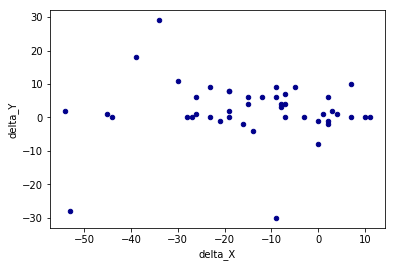

In [7]:
# df.dtypes
logger.info('X=change in PTSD; Y=change in faith. n=' + str(df.shape[1]))
df.plot.scatter(x='delta_X', y='delta_Y', c='DarkBlue')


## Aggregate changes
Independent (x) axis is change in PTSD. An aggregate drop of 5-10 points is reliable (not due to chance). An aggregate drop of 10-20 is clinically meaningful. (Monson et al., 2008).
Dependent (y) axis is change in faith. 
#### We will choose a significance level of 0.05; that is, $\alpha=0.05$.
Note: this one counts a 0 as an actual response, instead of a non-response. It has a very high p-value (third line in pink, below, p = 0.9103. Neither should it be used in publication.

INFO:__main__:Main equation: y = -0.010 x + 1.996
INFO:__main__:r^2 = 0.0003
INFO:__main__:p = 0.9103
INFO:__main__:std err: 0.0845


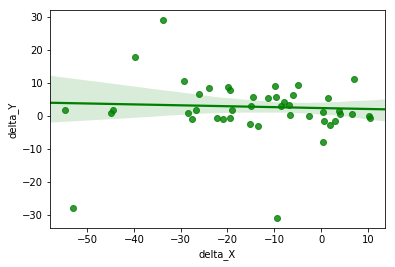

In [8]:
stat = stats()
stat.plot_and_stats(df=df, xlabel='delta_X', ylabel='delta_Y', color='g')

# In the survey, a 0 means "no answer"
The scale is 1-4, with 0 meaning "no answer."
This may explain some of the very negative deltas.
<br>
The code below does some adjustment to the zeroes. See adjust_zero to understand what's going on. 

## select
This routine is like a select statement for dataframes. 
## adjust_zero
### Overview
This routine replaces 0 answers in the DF with the previous answer.
### One response > 0, other = 0
If the respondent had a 1 for first response of "Repeated, disturbing dreams of the stressful experience?" and a 0 for the second, the second will be changed to a 1.
This will create a net change of 0 for the response.
### Both responses 0
If the responded had a 0 for both responses of "I pray daily" then an average of the non-zero responses for the first response will be calculated. The first and second will be set to that average.
This will also create a net change of 0 for the response.

## adjust_sum
This routine adjusts the sums for the Xs or Ys after adjust_zero has been executed on both vectors.

## adjust_delta
This routine calculates a new delta_X and delta_Y.



In [9]:
def XYnGen(label='X', start=1, end=20):
    # Generator like X1 through X20
    for x in range (start, end+1):
        yield '%s%d' % (label, x)

    
def select(df, columnName, matchMe):
    return df.loc[df[columnName] == matchMe]

def non_zero_avg(df, rowIndex, headers):
    logger.debug('Examining row %d' % rowIndex)
    
    row = df.iloc[rowIndex]
    df1 = row[headers]
    vector_sum = df1.sum()
    values = df1.tolist()
    logger.debug('values: ' + str(values))
    zero_count = values.count(0)
    avg = (vector_sum * 1.0) / (len(df1) - zero_count) # note if no 0s, will compute average from all
    logger.debug('Zero count: %d. Average=%f' % (zero_count, avg))
    return avg

def adjust_rows(df, row1index, row2index, nonZeroAvg, headers):
    logger.debug('Starting adjust_rows; comparing rows %d and %d.' % (row1index, row2index))
    row1 = df.iloc[row1index]
    row2 = df.iloc[row2index]
    for header in headers:
        cell1 = row1[header]
        cell2 = row2[header]
        logger.debug('comparing header %s with values %d and %d.' % (header, cell1, cell2))
        if (cell1 != 0) & (cell2 != 0):
            pass # neither is 0.
        elif (cell1 == 0) & (cell2 == 0):
            logger.debug('Setting both values to %f.' % nonZeroAvg)
            rowsToChange = [row1index, row2index]
            df.loc[rowsToChange, header] = nonZeroAvg
        elif (cell1 == 0):
            logger.debug('Setting row %d to %d.' % (row1index, cell2))
            df.loc[row1index, header] = cell2
        else:
            logger.debug('Setting row %d to %d.' % (row2index, cell1))
            df.loc[row2index, header] = cell1
            
def adjust_sum(df, rowIndex, sumLabel, headers):
    logger.debug('Starting adjust_sum for rows %d.' % rowIndex)
    row = df.iloc[rowIndex]
    s = row[headers].sum()
    df.loc[rowIndex, sumLabel] = s
    logger.debug('Exiting adjust_sum with a sum of %f.' % s)
    return s

def adjust_delta(df, row1index, row2index, sumLabel, deltaLabel):
    df.loc[row1index, deltaLabel] = float('NaN')
    diff= df.loc[row2index, sumLabel] - df.loc[row1index, sumLabel]
    df.loc[row2index, deltaLabel] = diff
    logger.debug('Exiting adjust_delta with row %d set to NaN and row %d set to %f.' % (row1index, row2index, diff))
    
    
def adjust_zero(df, subsetdf):
    logger.debug("Starting adjust_zero. Full set has %d rows. Subset has %d results." % (len(df), len(subsetdf)))
    xgen = XYnGen('X', 1, 20) # generates 'X1' through 'X20'
    ygen = XYnGen('Y', 1, 10) # generates 'Y1' through 'Y10'
    row1 = subsetdf.iloc[0]
    row2 = subsetdf.iloc[1]
    row1index = row1['index']
    row2index = row2['index']
    logger.debug('Comparing rows %d and %d.' % (row1index, row2index))
    xHeaders = list(xgen)
    yHeaders = list(ygen)
    nonZeroXAvg = non_zero_avg(df, row1index, xHeaders) 
    nonZeroYAvg = non_zero_avg(df, row1index, yHeaders)
    
    adjust_rows(df, row1index, row2index, nonZeroXAvg, xHeaders)
    adjust_rows(df, row1index, row2index, nonZeroYAvg, yHeaders)
    
    adjust_sum(df, row1index, 'X', xHeaders)
    adjust_sum(df, row2index, 'X', xHeaders)
    adjust_sum(df, row1index, 'Y', yHeaders)
    adjust_sum(df, row2index, 'Y', yHeaders)
    adjust_delta(df, row1index, row2index, 'X', 'delta_X')
    adjust_delta(df, row1index, row2index, 'Y', 'delta_Y')
    
    return df

def process_participants(df):
    indexColName = 'Participant'
    participants = df.Participant.unique()
    for participant in participants:
        logger.debug("Processing participant: " + participant)
        results = select(df, indexColName, participant)
        adjust_zero(df, results)
    return


In [10]:
df = remove_df_headers(raw_df, 1)
df.set_index('index') # Set the index 
df.dropna(axis=0, subset=['index'], inplace=True)
df = df.reset_index(drop=True)
process_participants(df)
df.head()

C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,Participant,date_survey_taken,date_between_survey,page1,page2,page3,X1,X2,X3,...,Y10,Y,delta_Y,Gender,Age,decade_age,Ethnicity,Education,Branch,Campaigns
0,0,3e6038ab-3ce6-4cf3-bcef-3fcd71a38712,2016-04-23 18:32:00,184.812,125.589,74.0889,71.5424,2.0,2,3.000000,...,3,35,NaN,Male,65-74 years old,6.0,White,"Some college credit, no degree",Army,",,,Vietnam,,"
1,1,3e6038ab-3ce6-4cf3-bcef-3fcd71a38712,2016-10-25 14:02:00,NaN,92.011,56.183,45.9487,1.0,2,3.000000,...,4,36,1.0,Male,65-74 years old,6.0,White,"Some college credit, no degree",Army,",,,Vietnam,,"
2,2,6303bc10-ff60-48a1-81a9-be8b37ea7fcd,2016-05-14 21:47:00,188.181,160.136,47.0266,34.2299,2.0,3.05882,3.058824,...,4,39,NaN,Male,25-34 years old,2.0,White,"Some college credit, no degree",Marine Corps,"OperationEnduringFreedom,OperationIraqiFreedom..."
3,3,6303bc10-ff60-48a1-81a9-be8b37ea7fcd,2016-11-19 02:07:00,NaN,249.503,80.6912,66.1119,1.0,3.05882,3.058824,...,4,39,0.0,Male,25-34 years old,2.0,White,"Some college credit, no degree",Marine Corps,"OperationEnduringFreedom,OperationIraqiFreedom..."
4,4,49694f11-0d24-4bd6-aa96-43a5c7872262,2016-05-15 07:56:00,197.4,251.572,130.025,127.526,3.0,3,1.000000,...,3,31,NaN,Male,25-34 years old,2.0,Hispanic or Latino,"Some college credit, no degree",Marine Corps,",OperationIraqiFreedom,,,,"


# Results after adjusting for 0 (no response)
#### Independent (x) axis is change in PTSD. An aggregate drop of 5-10 points is reliable (not due to chance). An aggregate drop of 10-20 is clinically meaningful. (Monson et al., 2008).
#### Dependent (y) axis is change in faith. 


INFO:__main__:X=change in PTSD; Y=change in faith. n=48
INFO:__main__:Main equation: y = -0.277 x + 0.487
INFO:__main__:r^2 = 0.1308
INFO:__main__:p = 0.0147
INFO:__main__:std err: 0.1088


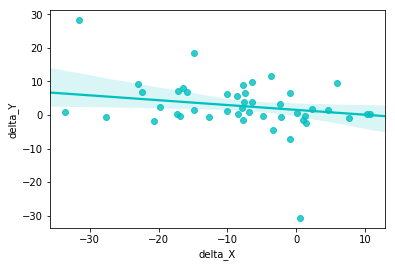

In [11]:
df2 = df.dropna(axis=0, subset=['delta_X'], inplace=False) # Drop the NaN on the first row for delta_X.#### Independent (x) axis is change in PTSD. An aggregate drop of 5-10 points is reliable (not due to chance). An aggregate drop of 10-20 is clinically meaningful. (Monson et al., 2008).
#### Dependent (y) axis is change in faith. 
n = df2.shape[1]
logger.info('X=change in PTSD; Y=change in faith. n=' + str(n))
stat.plot_and_stats(df=df2, xlabel='delta_X', ylabel='delta_Y', color='c')

## Analysis without zero response -- Discussion
#### Main equation: $y = -0.277x + 0.487$
#### $r^2 = 0.1308$
#### $p = 0.0147$
#### $standard error: 0.1088$
## Observations
$n=48$

## Interpretation
A lowering of PTSD scores is correlated with an increase in faith. For every 1 point increase in faith, an individual will enjoy a .277 point drop in PTSD scoring.
## Statistical significance
A p-value < 0.05 shows that the results are significant in the psychology or sociology domain.

# Breakdown of meaningful change
## find_response_category
Remember, meaningful changes at $\Delta x \leq -5$ and $\Delta x \leq -10$.

Individual has not responded: $\Delta x \gt -5$

Individual has responded to treatment: $\Delta x \leq -5$

Clinically meaningful response: $\Delta x \leq -10$.


C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
INFO:__main__:After response: df2 has 45 rows and 49 columns.
INFO:__main__:Label NOT responded to treatment, count 18, fraction 45.00%
INFO:__main__:Label responded to treatment, count 10, fraction 45.00%
INFO:__main__:Label responded, clinically meaningful, count 17, fraction 45.00%


"NOT responded to treatment": 40.00 %
"responded to treatment": 22.22 %
"responded, clinically meaningful": 37.78 %


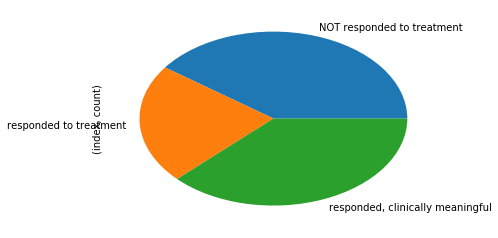

In [26]:
def find_response_category(deltaX):
    logger.debug('Starting find_response_category with deltaX of: ' + str(deltaX))
    if deltaX <= -10.0:
        return 'responded, clinically meaningful'
    elif deltaX <= -5.0:
        return 'responded to treatment'
    else:
        return 'NOT responded to treatment'

# Group by the change in deltaX
df2['response'] = df2['delta_X'].apply(find_response_category)
rCount, cCount = df2.shape
logger.info('After response: df2 has %d rows and %d columns.' % (rCount, cCount))

# Count the responses and display in a pie chart
responses = df2.groupby(df2['response']).agg(['count']).iloc[:,0]
responses.plot(kind='pie')

# Print the response labels and calculate percentages.
labels = responses.index
counts = responses.values
logger.debug('Calculating sizes. %d responses in df2. %d labels.' % (rCount, labels.size))
for i in range(labels.size):
    logger.debug('Label %s, count %d, fraction %.2f%%' % (labels[i], counts[i], rCount))
    print ('"%s": %.2f %%'% (labels[i], (100.0 * counts[i]) / rCount))


# Breakdown of meaningful change -- discussion
| Response | percentage |
| --- | --- |
| "NOT responded to treatment" | 37.50% |
| responded to treatment" | 20.83% |
| responded, clinically meaningful"| 35.42% |

The majority of participants 56.25% (=20.83% + 35.42%) had responded to treatment. More than a third (35.42%) had a clinically meaningful response to treatment. 

## How age corresonds to decade_age
| Age | decade_age |
| --- | --- |
| 18-24 years old | 1 |
| 25-34 years old | 2 |
| 35-44 years old | 3 |
| 45-54 years old | 4 |
| 55-64 years old | 5 |
| 65-74 years old | 6 |

## Were there changes dependent on age?
The code below groups the respondents by decade_age, as follows:

response                          decade_age
NOT responded to treatment        1.0           1
                                  2.0           2
                                  3.0           6
                                  4.0           6
                                  5.0           3
responded to treatment            2.0           4
                                  3.0           3
                                  4.0           3
responded, clinically meaningful  1.0           1
                                  2.0           5
                                  3.0           8
                                  4.0           2
                                  6.0           1
Name: response, dtype: int64
decade_age  response                        
1.0         NOT responded to treatment          1
            responded, clinically meaningful    1
2.0         NOT responded to treatment          2
            responded to treatment              4
            responded, clinical

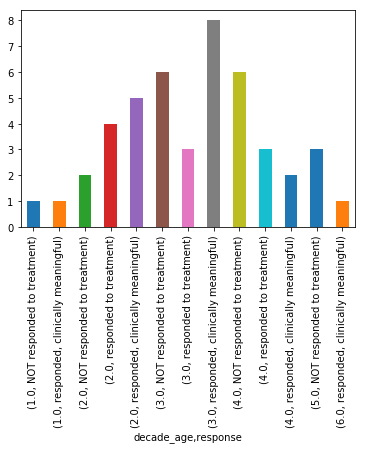

In [27]:
ages = df2.groupby(['response','decade_age'])['response'].count()
print(ages)

ages2 = df2.groupby(['decade_age','response'])['response'].count()
print(ages2)
ages2.plot(kind='bar', stacked=True)
# df2[['response','decade_age']].plot(kind='bar', stacked=True)
#sns.catplot(x='response', y='decade_age', data=ages2)


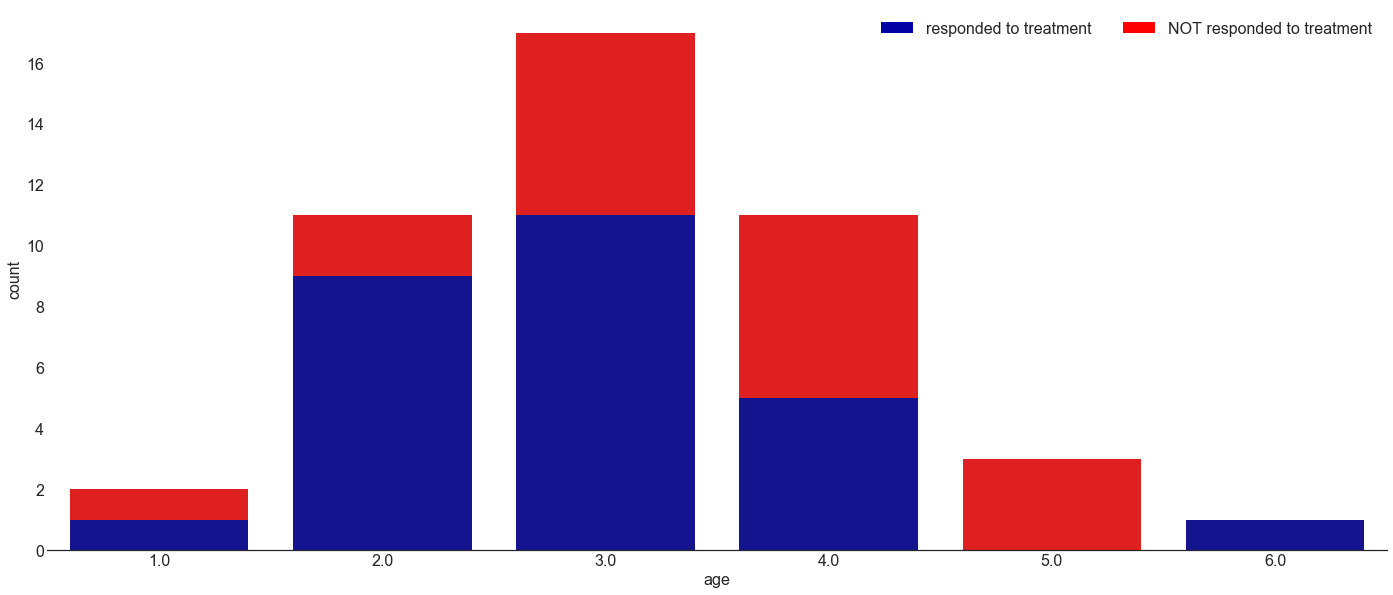

In [28]:
# code for bar chart modified from https://randyzwitch.com/creating-stacked-bar-chart-seaborn/
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

ageTotals = df2.groupby(['decade_age'])['response'].count()
logger.debug('Totals by age:')
# print (ageTotals.head(6))

responded = df2.loc[df2['response'].isin(['responded, clinically meaningful','responded to treatment'])] # subset of df2 that responded
respondedTotals = responded.groupby(['decade_age'])['response'].count() # counts of subset
respondedTotals.loc[5] = 0 # Had to force one value with 0 count to 0. 
# print (respondedTotals.values)

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = ageTotals.index, y = ageTotals.values, color = "red")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = respondedTotals.index, y = respondedTotals.values, color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['responded to treatment', 'NOT responded to treatment'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("count")
bottom_plot.set_xlabel("age")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
    


## Observations about age
Those aged 25 to 34 had a responded well to treatment, proportionally speaking, at 81.8% (= 9 / 11).<br>
Response declined in the 35 to 44 age range, at 64.7% (= 11 / 17).
The response declined even more in the 45 to 54 age range, at 45.5% (= 5 / 11).<br>
Those in the 55 to 64 age range did not respond to treatment (0 / 3). 

## Thoughts about initial PTSD scoring
We were wondering whether those with high initial PTSD scores (pre-survey, before the program) might be linked to age our campaign.

INFO:__main__:Main equation: y = -4.258 x + 61.300
INFO:__main__:r^2 = 0.1383
INFO:__main__:p = 0.0119
INFO:__main__:std err: 1.6208
INFO:__main__:n = 45


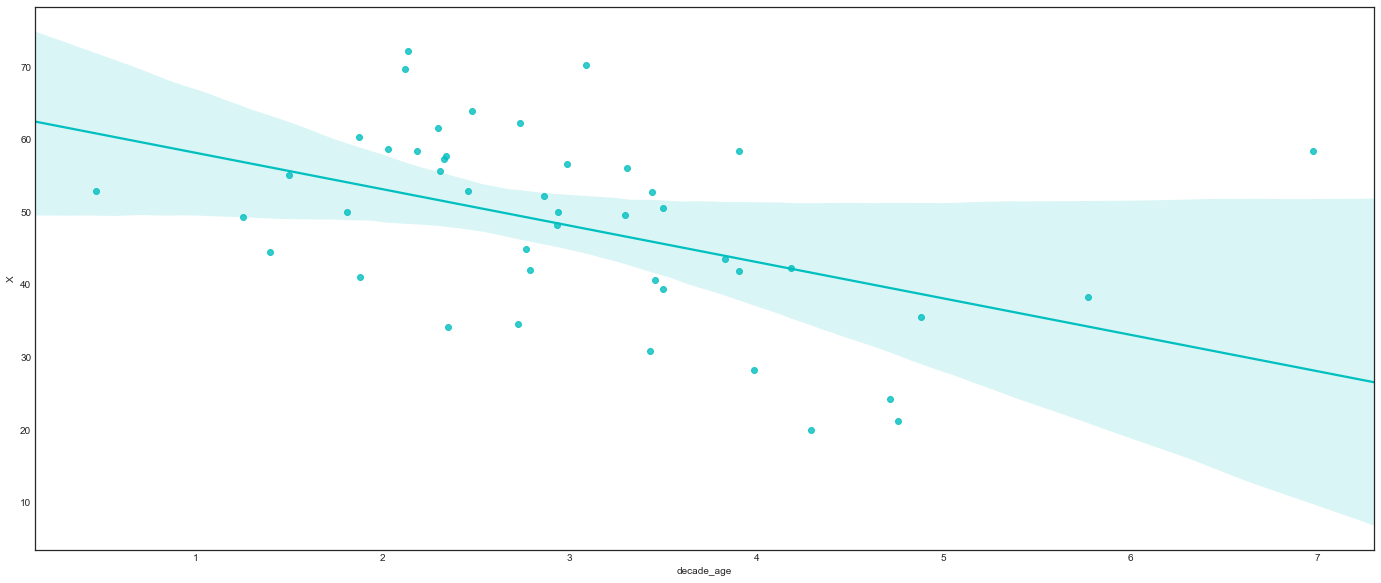

In [30]:
# Create df3 to be the measurements pre-survey. 
df3 = df.dropna(subset=['date_between_survey']) # if date_between_survey is NaN, then it's pre-survey

stat.plot_and_stats(df=df3, xlabel='decade_age', ylabel='X', color='c')
rCount, _ = df3.shape
logger.info('n = %d' % rCount)

## Thoughts about initial PTSD scoring -- Discussion
#### Main equation: $y = -4.258 x + 61.300$
#### $r^2 = 0.1383$
#### $p = 0.0119$
#### $standard error: 1.6208$
## Observations
$n=45$
<br>
The dependent x-axis has the decade-age (e.g., 1=18-24, ... 5=55-64 years old). The independent y-axis shows the initial (pre-program) PTSD scoring. 

## Interpretation
A higher initial PTSD scores is associated with a younger age. For every increase in decade there is a 4.258 point decrease in initial PTSD score. 
## Statistical significance
A p-value < 0.05 shows that the results are significant in the psychology or sociology domain.

## Were the changes dependent on branch?

## Were the changes dependent on campaign?

Discussion with Curtis on 15Oct18. 
### Count how many campaigns
Enduring freedom (Afghanistan) & Iraqi freedom: Same time, different locales
Desert storm  & Iraqi freedom: different time, same locale
Perhaps no response for younger people because more trauma. 

### Count distance from end of campaign: no, because some campaigns are still active
#### If multiple campaigns, perhaps take an average.

# Could you take out the "faith is extremely important to me" ? 
## Most said yes. Don't know if you'd see a larger difference in faith.